In [1]:
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
import os
import pandas as pd

In [2]:
pd.read_parquet("/workplace/tests/2022-10-23 14:06:10.948145_ResNet32_CIFAR100/results/cascade_training.parquet")

,accuracy,val_accuracy,loss,val_loss,training_time,training_time_epoch,batch_size,trainable_params,non_trainable_params,total_params_vector,Test_acc,Epoch_test_start,Cascade_type
0,"[0.2753861032459725, 0.2381178112611203, 0.247...","[0.24723637104034424, 0.24185454845428467, 0.2...","[2.9638479066367953, 3.0753472376083306, 2.864...","[3.3351640701293945, 2.958730459213257, 3.2043...",7356.100297,1471.220059,32,"[24059136.0, 24059136.0, 24059136.0, 24059136....","[276196.0, 276196.0, 276196.0, 276196.0, 27619...",24335332,0.307,14,RSCL


In [3]:
pd.read_parquet("/workplace/tests/2022-10-23 14:06:10.948145_ResNet32_CIFAR100/results/normal_training.parquet")

,accuracy,val_accuracy,loss,val_loss,training_time,training_time_epoch,batch_size,Test_acc,trainable_params,non_trainable_params,total_params
0,"[0.03910255501069419, 0.06992224698274928, 0.0...","[0.057363636791706085, 0.08063636720180511, 0....","[4.106273132032564, 3.695395024251419, 3.52890...","[4.254872798919678, 7.7109694480896, 9.3481187...",10514.588781,210.291776,32,0.2986,24282212,53120,24335332


In [3]:
tf.config.list_physical_devices('GPU')

2022-07-10 17:09:26.204700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 17:09:26.291619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 17:09:26.291852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-07-10 17:09:26.995698: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-10 17:09:26.996614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 17:09:26.996906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 17:09:26.997154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

In [5]:
os.makedirs("./checkpoints/simple_DNN",exist_ok=True)

file_path = "./checkpoints/simple_DNN/cp-{epoch:04d}.ckpt"
callbacks = [
             EarlyStopping(
                 monitor="val_loss",
                 min_delta = 0.005,
                 patience=5,
                 restore_best_weights=False,
                 verbose=1
             ),
             ModelCheckpoint(
                 filepath=file_path,
                 monitor="val_los",
                 verbose=1,
                 save_weights_only=True,

             )
]

class ResNet_Model(Model):
  def __init__(self, num_classes, layers_num):
    model_2 = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
    headModel = model_2.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    for _ in range(layers_num-1):
      headModel = Dense(256, activation="relu")(headModel)
    headModel = Dense(num_classes, activation="softmax")(headModel)
    self.model = Model(inputs=model_2.input, outputs=headModel)
    print(self.model.summary())
  

class VGG16_Model(Model):
  def __init__(self, input_shape, num_classes, layers):
    model_2 = VGG16(weights='imagenet',input_tensor=Input(shape=input_shape),include_top=False)

    model = Sequential()
    model.add(Input(shape=input_shape))
    for layer in model_2.layers[1:-1]:
      model.add(layer)
    
    for _ in range(layers-1):
      model.add(Dense(254, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    self.model = model
    print(self.model.summary())

class SimpleDNN_Model():
  def __init__(self,input_shape, num_layers, num_classes):
    self.input_shape = input_shape
    self.num_layers = num_layers
    self.num_classes = num_classes

  def create_model(self):
    input = Input(shape=self.input_shape)
    output = Flatten(input_shape=(244,244,3))(input)
    for _ in range(self.num_layers-1):
      output = Dense(256, activation="relu")(output)
    output = Dense(self.num_classes, activation="softmax")(output)

    self.model = Model(inputs=input, outputs=output)
    loss = CategoricalCrossentropy(
              from_logits=False,
              label_smoothing=0.0,
              axis=-1,
              name='categorical_crossentropy'
            )
    self.model.compile(optimizer="Adam", loss=loss)
    return self.model
  
  @staticmethod
  def prepare_data(X_data):
    return X_data/255

In [41]:
X_train = np.load("./data_calibrated/MNIST/X_train.npy", allow_pickle=True)
y_train = np.load("./data_calibrated/MNIST/y_train.npy", allow_pickle=True)
X_valid = np.load("./data_calibrated/MNIST/X_valid.npy", allow_pickle=True)
y_valid = np.load("./data_calibrated/MNIST/y_valid.npy", allow_pickle=True)
X_test = np.load("./data_calibrated/MNIST/X_test.npy", allow_pickle=True)
y_test = np.load("./data_calibrated/MNIST/y_test.npy", allow_pickle=True)
# X_train = np.expand_dims(X_train, -1)
# X_valid = np.expand_dims(X_valid, -1)
# X_test = np.expand_dims(X_test, -1)
# # skalowanie danych
# X_train = X_train/255
# X_valid = X_valid/255
# X_test = X_test/255
# # Zczytywanie kształtu danych wejściowych i wyjściowych
# input_shape = X_train.shape[1:]
# output_shape = len(np.unique(y_train))
# # Tworzenie modelu
# model_class = SimpleDNN_Model(input_shape, 10, output_shape)
# model = model_class.create_model()
# # Przygotowywanie danych wyjściowych
# y_train = to_categorical(y_train)
# y_valid = to_categorical(y_valid)

In [40]:
from sklearn.utils import shuffle

X_train_new = np.array([])
X_valid_new = np.array([])
X_test_new = np.array([])
y_train_new = np.array([])
y_valid_new = np.array([])
y_test_new = np.array([])
for i in np.unique(y_train):
    X_train_temp = X_train[y_train == i][:500]
    X_valid_temp = X_valid[y_valid == i][:50]
    X_test_temp = X_test[y_test == i][:50]
    y_train_temp = y_train[y_train == i][:500]
    y_valid_temp = y_valid[y_valid == i][:50]
    y_test_temp = y_test[y_test == i][:50]
    if X_train_new.size ==0:
        X_train_new = X_train_temp
        X_valid_new = X_valid_temp
        X_test_new = X_test_temp
        y_train_new = y_train_temp
        y_valid_new = y_valid_temp
        y_test_new = y_test_temp
    else:
        X_train_new = np.concatenate([X_train_new, X_train_temp])
        X_valid_new = np.concatenate([X_valid_new, X_valid_temp])
        X_test_new = np.concatenate([X_test_new, X_test_temp])
        y_train_new = np.concatenate([y_train_new, y_train_temp])
        y_valid_new = np.concatenate([y_valid_new, y_valid_temp])
        y_test_new = np.concatenate([y_test_new, y_test_temp])

X_train_new, y_train_new = shuffle(X_train_new, y_train_new, random_state=0)
X_valid_new, y_valid_new = shuffle(X_valid_new, y_valid_new, random_state=0)
X_test_new, y_test_new = shuffle(X_test_new, y_test_new, random_state=0)

with open("./data_calibrated/MNIST/X_train.npy", "wb") as f:
    np.save(f, X_train_new)
with open("./data_calibrated/MNIST/X_valid.npy", "wb") as f:
    np.save(f, X_valid_new)
with open("./data_calibrated/MNIST/X_test.npy", "wb") as f:
    np.save(f, X_test_new)
with open("./data_calibrated/MNIST/y_train.npy", "wb") as f:
    np.save(f, y_train_new)
with open("./data_calibrated/MNIST/y_valid.npy", "wb") as f:
    np.save(f, y_valid_new)
with open("./data_calibrated/MNIST/y_test.npy", "wb") as f:
    np.save(f, y_test_new)
    

(5000, 28, 28)
(500, 28, 28)
(500, 28, 28)
[0 1 2 3 4 5 6 7 8 9]


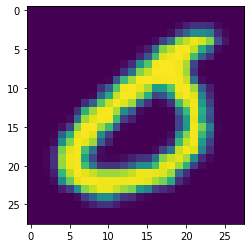

0


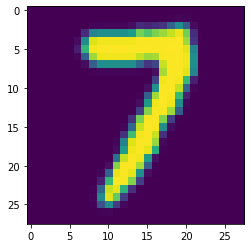

7


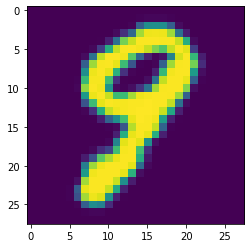

9


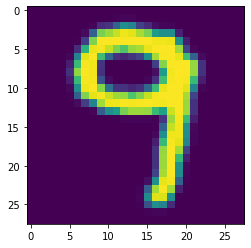

9


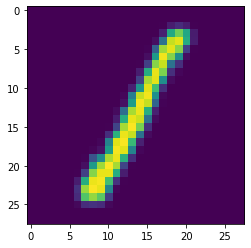

1


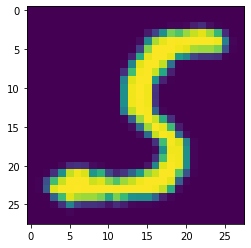

5


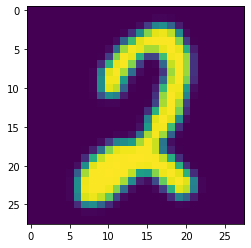

2


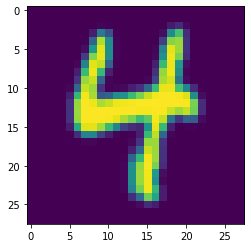

4


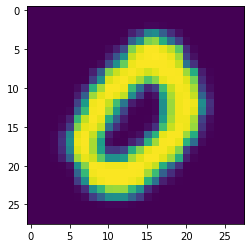

0


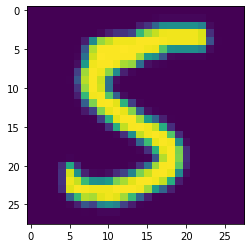

5


In [42]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(np.unique(y_train))
for i in range(10):
    plt.imshow(X_train[i])
    plt.show()
    print(y_train[i])

In [44]:
11//5

2

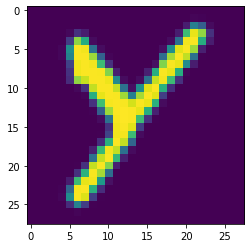

In [13]:
plt.imshow(X_train[609])

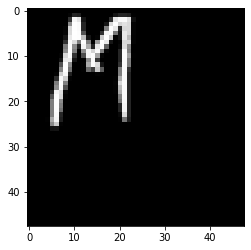

In [11]:

from keras.preprocessing.image import img_to_array, array_to_img
def make_3_channels(X_data):
    X_data_new = np.zeros((X_data.shape[0], X_data.shape[1], X_data.shape[2], 3))
    X_data_new[:,:,:,0] = X_data
    X_data_new[:,:,:,1] = X_data
    X_data_new[:,:,:,2] = X_data
    return X_data_new

def make_compitable_with_VGG16(X_data):
    if X_data.shape[1] < 48:
        X_data_new = np.zeros((X_data.shape[0],48,48,3))
        X_data_new[:,:X_data.shape[1],:X_data.shape[2],:] = X_data
    return X_data_new

X_train_new = make_3_channels(X_train[:10])
X_train_new = make_compitable_with_VGG16(X_train_new)
plt.imshow(X_train_new[4])

In [6]:
# Fitowanie modelu
#model.fit(X_train, y_train, validation_data=( X_valid, y_valid),epochs=50, callbacks=[callbacks], batch_size=64)

#prediction = np.argmax(model.predict(X_test), axis=1)
#metrics = accuracy_score(y_test, prediction)

In [7]:
model.load_weights("./checkpoints/simple_DNN/cp-0001.ckpt")

learning_type = "FBCL"
dense_layers = []
for i, layer in enumerate(model.layers):
  if "dense" in layer.name:
    layer.trainable = False
    dense_layers.append(i)
if learning_type == "BFCL": 
  dense_layers.reverse()
elif learning_type == "RSCL":
  shuffle(dense_layers)
for i in dense_layers:
  model.layers[i].trainable = True
  # q = Queue()
  # q.put(ret)
  # p = Process(target=train_model, args=(model, X_train, y_train, X_valid, y_valid, q))
  # p.start()
  # p.join()
  # model, rest = q.get()
  model.fit(X_train, y_train, validation_data=( X_valid, y_valid),epochs=1, batch_size=64)
  model.layers[i].trainable = False
  cuda.select_device(0)
  cuda.close()
prediction = np.argmax(model.predict(X_test), axis=1)
metrics = accuracy_score(y_test, prediction)

2022-06-16 18:38:04.640879: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1313228224 exceeds 10% of free system memory.
2022-06-16 18:38:05.454319: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1313228224 exceeds 10% of free system memory.


6531/6544 [============================>.] - ETA: 0s - loss: 0.5729

2022-06-16 18:38:31.922385: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 437741696 exceeds 10% of free system memory.
2022-06-16 18:38:32.183866: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 437741696 exceeds 10% of free system memory.


6544/6544 [==============================] - 31s 5ms/step - loss: 0.5728 - val_loss: 0.5658


: 

: 

In [15]:
cuda.select_device(0)
cuda.close()